In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import math

import pickle as pkl
from sklearn.preprocessing import minmax_scale, MinMaxScaler
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.patches import Patch
import matplotlib.cm as cm
from matplotlib.colors import Normalize

import itertools

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_gp='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/moransi/sfintegrated/'

In [5]:
adata_rn_b=sc.read(path_data+'data_rawnorm_integrated_analysed_beta_v1s1_sfintegrated.h5ad')
adata_rn_b.shape

(102143, 30672)

In [6]:
# reload
genes_hc=pd.read_table(path_gp+'gene_hc_t'+str(2.4)+'.tsv',sep='\t',index_col=0)

## GP scores across cells

In [7]:
# Compute GP scores 
gene_cl='hc'
adata_rn_b.obs.drop([col for col in adata_rn_b.obs.columns 
                     if 'gene_score_cluster_'+gene_cl in col],axis=1,inplace=True)
for ct in sorted(genes_hc[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    sc.tl.score_genes(adata_rn_b, 
                      gene_list=genes_hc.index[genes_hc[gene_cl]==ct], 
                     score_name=score_name, use_raw=False)
    adata_rn_b.obs[score_name+'_scaled']=minmax_scale(adata_rn_b.obs[score_name])

GP score distn across cells

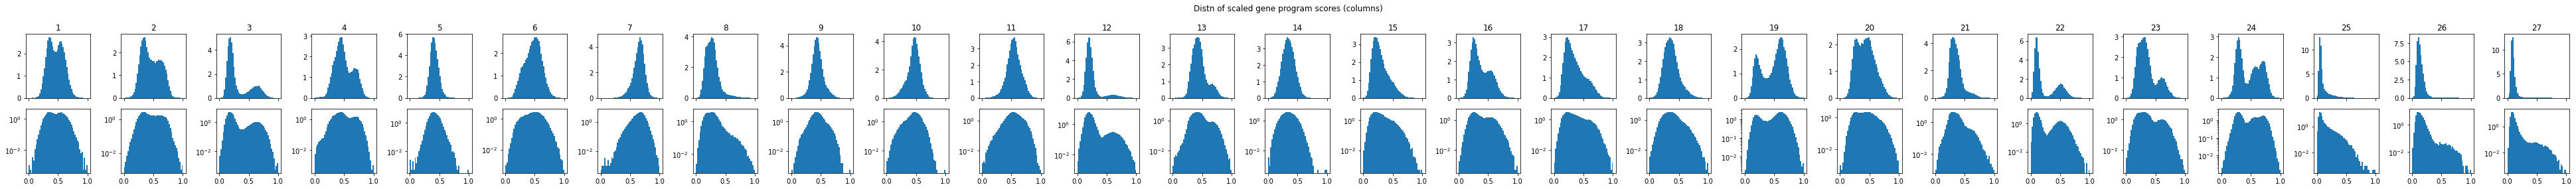

In [9]:
cols=sorted(genes_hc.hc.unique())
fig,axs=plt.subplots(2,len(cols),
                    figsize=(2*len(cols),2*2),
                    sharex=True,sharey=False)
for j,gp in enumerate(cols):
    axs[0,j].hist(adata_rn_b.obs['gene_score_cluster_hc'+str(gp)+'_scaled'],
                  bins=50,density=True)
    axs[0,j].set_title(gp)
    axs[1,j].hist(adata_rn_b.obs['gene_score_cluster_hc'+str(gp)+'_scaled'],
                  bins=50,density=True)
    axs[1,j].set_yscale('log')
fig.suptitle('Distn of scaled gene program scores (columns)')
fig.tight_layout()

C: It seems taht a few GPs have outliers, thus redo norm by removing N cells with highest/lowest scores

Plot GP tails to find out N cells in high/low regions

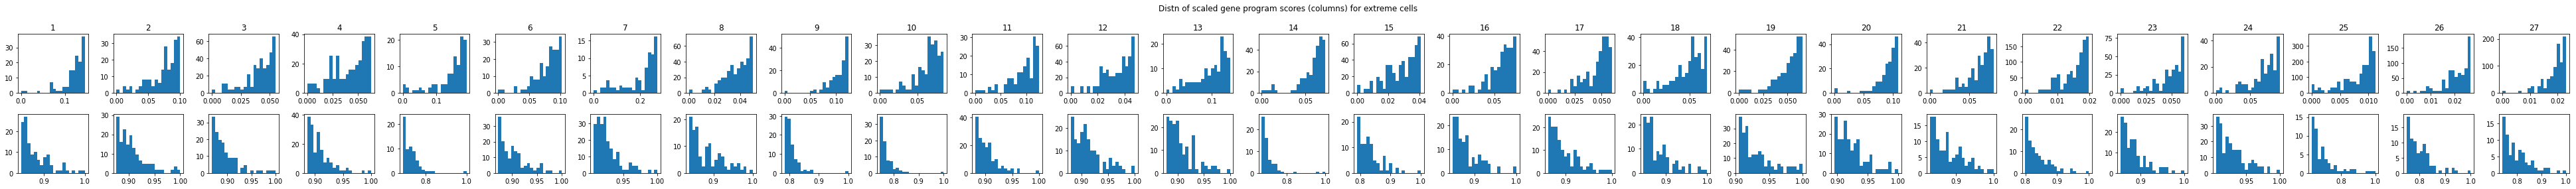

In [15]:
# Plot bottom (top plot) and upper (bottom plot) tails of GP score distn for each GP
cols=sorted(genes_hc.hc.unique())
fig,axs=plt.subplots(2,len(cols),
                    figsize=(2*len(cols),2*2),
                    sharex=False,sharey=False)
for j,gp in enumerate(cols):
    axs[0,j].hist(adata_rn_b.obs['gene_score_cluster_hc'+str(gp)+'_scaled'
                                ].sort_values().head(100),
                  bins=20,density=True)
    axs[0,j].set_title(gp)
    #axs[0,j].set_yscale('log')
    axs[1,j].hist(adata_rn_b.obs['gene_score_cluster_hc'+str(gp)+'_scaled'
                                ].sort_values().tail(100),
                  bins=20,density=True)
    #axs[1,j].set_yscale('log')
fig.suptitle('Distn of scaled gene program scores (columns) for extreme cells')
fig.tight_layout()

C: removing top/bottom 20 cells before normalisation range calculation would  solve the issue of outlier effect

In [8]:
# rescale scores without outliers
# Gene cluster scores 
gene_cl='hc'
for ct in sorted(genes_hc[gene_cl].unique()):
    score_name='gene_score_cluster_'+gene_cl+str(ct)
    bottom=adata_rn_b.obs[score_name].nsmallest(20).max()
    top=adata_rn_b.obs[score_name].nlargest(20).min()
    scores_clip=adata_rn_b.obs[score_name][
        (adata_rn_b.obs[score_name]<top).values & (adata_rn_b.obs[score_name]>bottom).values]
    adata_rn_b.obs[score_name+'_scaled_out']=MinMaxScaler(clip=True).fit(
        scores_clip.values.reshape(-1,1)
        ).transform(adata_rn_b.obs[score_name].values.reshape(-1,1))

<ipython-input-8-ffdf6c4d751a>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_rn_b.obs[score_name+'_scaled_out']=MinMaxScaler(clip=True).fit(
<ipython-input-8-ffdf6c4d751a>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_rn_b.obs[score_name+'_scaled_out']=MinMaxScaler(clip=True).fit(
<ipython-input-8-ffdf6c4d751a>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

Replot re-normalised scores

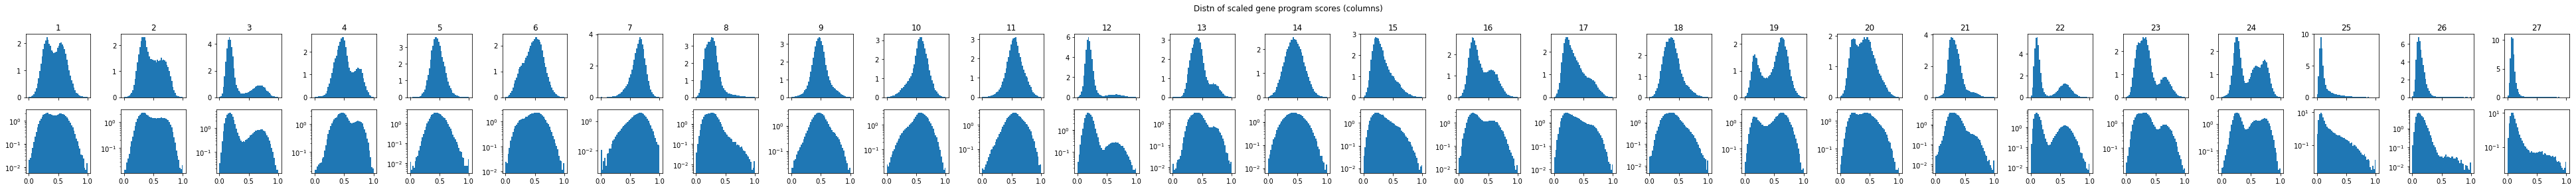

In [47]:
cols=sorted(genes_hc.hc.unique())
fig,axs=plt.subplots(2,len(cols),
                    figsize=(2*len(cols),2*2),
                    sharex=True,sharey=False)
for j,gp in enumerate(cols):
    axs[0,j].hist(adata_rn_b.obs['gene_score_cluster_hc'+str(gp)+'_scaled_out'],
                  bins=50,density=True)
    axs[0,j].set_title(gp)
    axs[1,j].hist(adata_rn_b.obs['gene_score_cluster_hc'+str(gp)+'_scaled_out'],
                  bins=50,density=True)
    axs[1,j].set_yscale('log')
fig.suptitle('Distn of scaled gene program scores (columns)')
fig.tight_layout()

How are GP scores (cols) distn within cell clusters (rows)

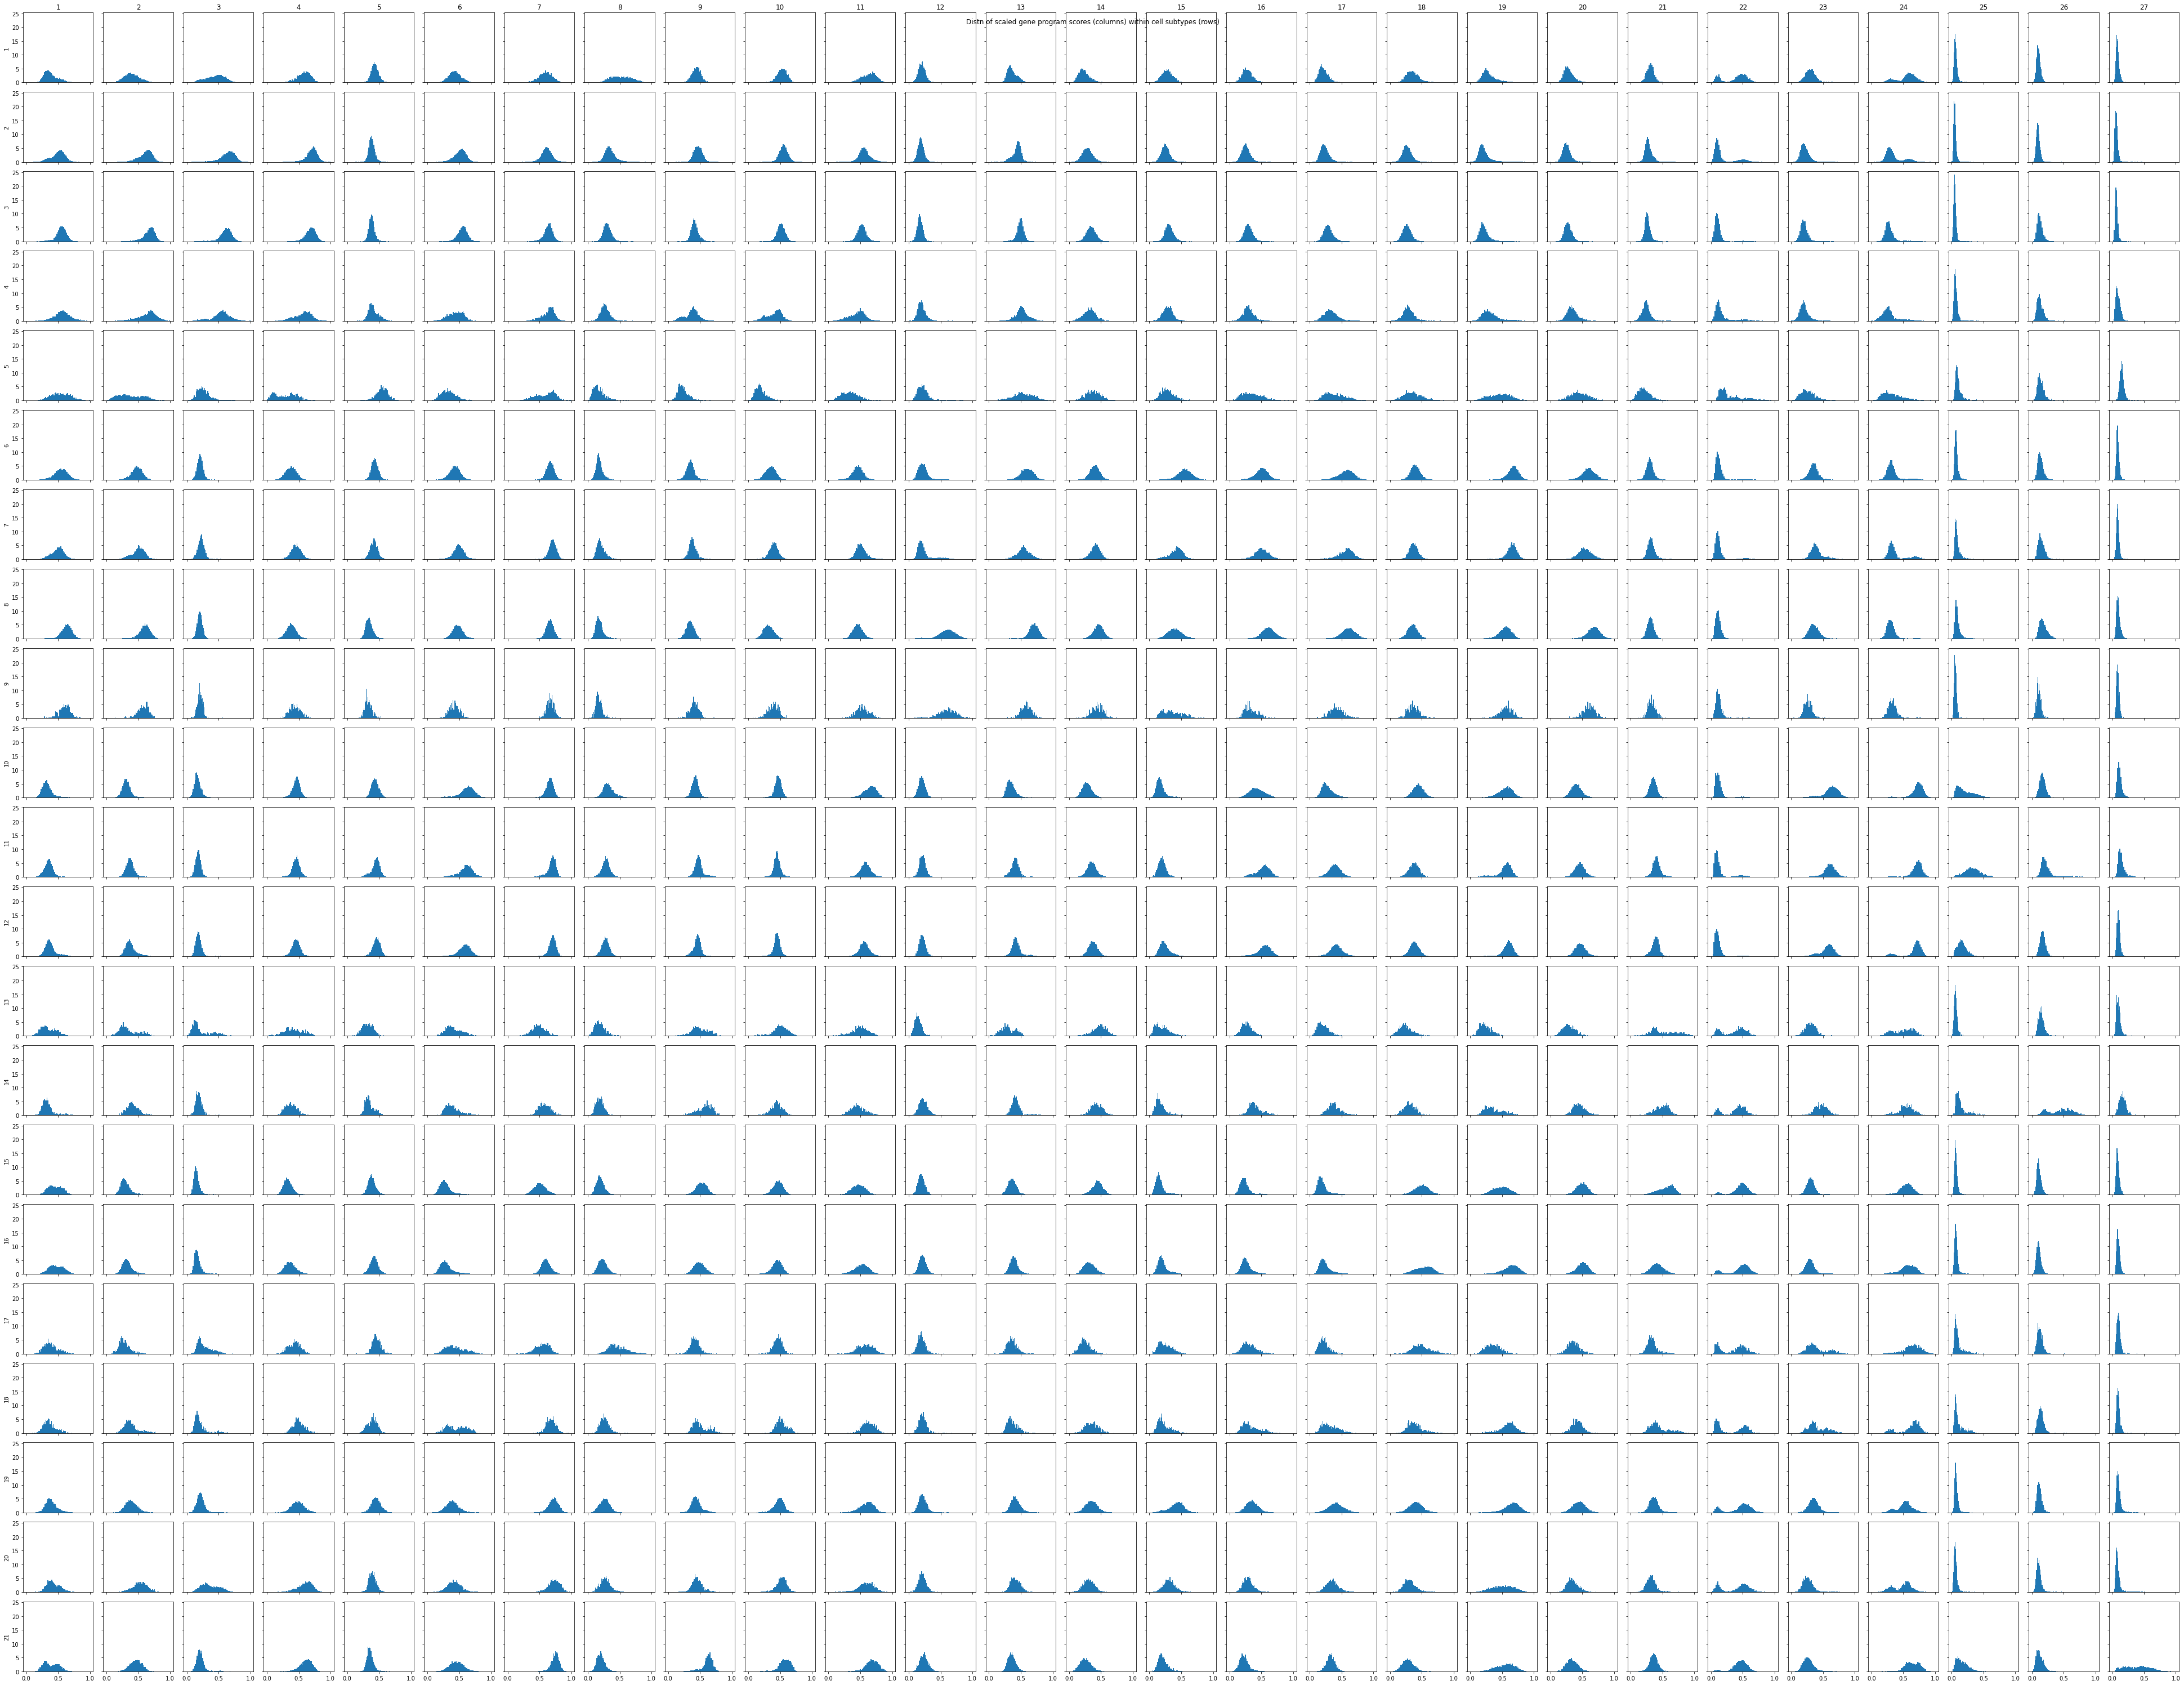

In [10]:
rows=sorted(adata_rn_b.obs.hc_gene_programs.unique())
cols=sorted(genes_hc.hc.unique())
fig,axs=plt.subplots(len(rows),len(cols),
                    figsize=(2*len(cols),2*len(rows)),
                    sharex=True,sharey=True)
for i,cl in enumerate(rows):
    for j,gp in enumerate(cols):
        axs[i,j].hist(adata_rn_b.obs.query('hc_gene_programs==@cl'
                                          )['gene_score_cluster_hc'+str(gp)+'_scaled'],
                      bins=50,density=True)
        if i == 0:
            axs[i,j].set_title(gp)
        if j == 0:
            axs[i,j].set_ylabel(cl)
fig.suptitle('Distn of scaled gene program scores (columns) within cell subtypes (rows)')
fig.tight_layout()

C: Not all gp scores within clusters are normally distributed. 

C: Most gene program distributions within cell clusters are unimodal (and not too strongly skewed) and can thus be well summarized by the mean. 


## Compare means of scaled gp values
Do not use effect size metrics (such as cllif's delta) as they look at differences between 2 groups and do not account for relative variability across all groups (e.g. how much does GP differ between two groups compared to across all groups - i.e. is variation relevant for interpretation). Thus, using such metrics, two gene programs that are relatively similar across two cell clusters compared to other cell clusters still get a high score if they are separated enough.


Do not do comparisons with a statistical test as the p-vals are too often strongly significant due to very large number of cells in each cluster.


Thus, we compare means of GP values scaled across cells. To make the range of GP values and thus GP differences more comparable across GPs we above excluded outliers in scaling as else they would affect the scaled GP score distn.

In [11]:
# Collect data for combined comparison plot
diffs_plot={}

### Healthy vs diseased for T2D
adult2 vs db/db+mSTZ for VSG and STZ datasets

#### Subset to non-treated
When comparing adult2 and db/db+mSTZ from VSG and STZ subset to only healthy and diabetic samples - exclude treated ones.

In [126]:
# Compute GP differences between clusters
score_cols=[c for c in adata_rn_b.obs.columns if 
            c.startswith('gene_score_cluster_hc') and c.endswith('_scaled_out')]
diffs=[]
for study,(samples1,samples2) in [(
    'VSG',
    [['VSG_MUC13633_chow_WT','VSG_MUC13634_chow_WT'],
     [ 'VSG_MUC13639_sham_Lepr-/-','VSG_MUC13641_sham_Lepr-/-']]),
    ('STZ',
    [['STZ_G1_control'],
     ['STZ_G2_STZ']])]:
    cells1=adata_rn_b.obs.query('study==@study & study_sample_design in @samples1 & '+\
        'hc_gene_programs_parsed=="adult2"').index
    cells2=adata_rn_b.obs.query('study==@study & study_sample_design in @samples2 & '+\
        'hc_gene_programs_parsed=="db/db+mSTZ"').index
    print(study,'N cells cl1,2:',len(cells1),len(cells2))
    diff=pd.DataFrame(adata_rn_b.obs.loc[cells2,score_cols].mean()-\
                    adata_rn_b.obs.loc[cells1,score_cols].mean()).rename({0:'diff'},axis=1)
    diff['dataset']=adata_rn_b.obs.query('study==@study')['study_parsed'][0]
    diffs.append(diff)
diffs=pd.concat(diffs)
diffs['gp']=[i.replace('gene_score_cluster_hc','').replace('_scaled_out','') 
             for i in diffs.index]
diffs['dataset']=pd.Categorical(
    values=diffs['dataset'],ordered=True,
    categories=[c for c in adata_rn_b.uns['study_parsed_order'] 
                if c in diffs['dataset'].unique()])

VSG N cells cl1,2: 812 3064
STZ N cells cl1,2: 3921 694


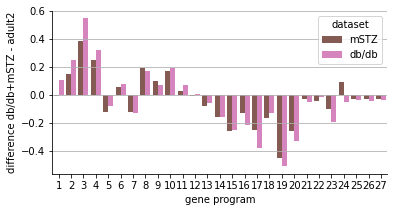

In [127]:
# Plot GP diffs
fig,ax=plt.subplots(figsize=(6,3))
sb.barplot(x="gp", y="diff",  data=diffs,
           hue='dataset',dodge=True,ax=ax,
          palette=dict(zip(adata_rn_b.uns['study_parsed_order'],
                           adata_rn_b.uns['study_parsed_colors']))
          )
ax.set_ylabel('difference db/db+mSTZ - adult2')
ax.set_xlabel('gene program')
ax.grid(axis='y')
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Same as above, but use all samples from the datasets

In [ ]:
# Compute GP differences between clusters
score_cols=[c for c in adata_rn_b.obs.columns if 
            c.startswith('gene_score_cluster_hc') and c.endswith('_scaled_out')]
diffs=[]
for study in ['VSG',"STZ"]:
    cells1=adata_rn_b.obs.query('study==@study & hc_gene_programs_parsed=="adult2"').index
    cells2=adata_rn_b.obs.query('study==@study & hc_gene_programs_parsed=="db/db+mSTZ"').index
    print(study,'N cells cl1,2:',len(cells1),len(cells2))
    diff=pd.DataFrame(adata_rn_b.obs.loc[cells2,score_cols].mean()-\
                    adata_rn_b.obs.loc[cells1,score_cols].mean()).rename({0:'diff'},axis=1)
    diff['dataset']=adata_rn_b.obs.query('study==@study')['study_parsed'][0]
    diffs.append(diff)
diffs=pd.concat(diffs)
diffs['gp']=[i.replace('gene_score_cluster_hc','').replace('_scaled_out','') 
             for i in diffs.index]
diffs['dataset']=pd.Categorical(
    values=diffs['dataset'],ordered=True,
    categories=[c for c in adata_rn_b.uns['study_parsed_order'] 
                if c in diffs['dataset'].unique()])

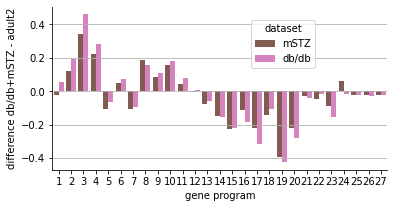

In [125]:
# plot GP diffs
fig,ax=plt.subplots(figsize=(6,3))
sb.barplot(x="gp", y="diff",  data=diffs,
           hue='dataset',dodge=True,ax=ax,
          palette=dict(zip(adata_rn_b.uns['study_parsed_order'],
                           adata_rn_b.uns['study_parsed_colors']))
          )
ax.set_ylabel('difference db/db+mSTZ - adult2')
ax.set_xlabel('gene program')
ax.grid(axis='y')
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(0.8,0.95),title='dataset')

C: Excluding or including anti-diabetic treated samples that map in compared clusters as expected leads to similar results. - E.g. if cells map to the same cluster they have similar expression.

### Healthy vs diseased for t1D and T2D on one plot
adul2 vs db/db+mSTZ or NOD-D per dataset
Similar as above, but now compare healthy cluster (adult2) to diseased cluster for all diabetes models.

In [9]:
# Compute GP differences between clusters
score_cols=[c for c in adata_rn_b.obs.columns if 
            c.startswith('gene_score_cluster_hc') and c.endswith('_scaled_out')]
diffs=[]
for study,cl2 in [('VSG','db/db+mSTZ'),('STZ','db/db+mSTZ'),('NOD_elimination','NOD-D')]:
    cells1=adata_rn_b.obs.query('study==@study & hc_gene_programs_parsed=="adult2"').index
    cells2=adata_rn_b.obs.query('study==@study & hc_gene_programs_parsed==@cl2').index
    print(study,'N cells cl1,2:',len(cells1),len(cells2))
    diff=pd.DataFrame(adata_rn_b.obs.loc[cells2,score_cols].mean()-\
                    adata_rn_b.obs.loc[cells1,score_cols].mean()).rename({0:'diff'},axis=1)
    diff['gp']=[i.replace('gene_score_cluster_hc','').replace('_scaled_out','') 
             for i in diff.index]
    diff['dataset']=adata_rn_b.obs.query('study==@study')['study_parsed'][0]
    
    # Compute significance
    diff['pval']=np.nan
    for gp in diff.gp:
        gp_name='gene_score_cluster_hc'+gp+'_scaled_out'
        diff.at[gp_name,'pval']=mannwhitneyu(
            adata_rn_b.obs.loc[cells2,gp_name].values,
            adata_rn_b.obs.loc[cells1,gp_name].values )[1]
    diff['padj']=multipletests(diff['pval'],method='fdr_bh')[1]
    
    diffs.append(diff)
    display(diff)
diffs=pd.concat(diffs)
diffs['dataset']=pd.Categorical(
    values=diffs['dataset'],ordered=True,
    categories=[c for c in adata_rn_b.uns['study_parsed_order'] 
                if c in diffs['dataset'].unique()])

VSG N cells cl1,2: 1007 10968


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,0.055132,1,db/db,9.721935e-71,1.093718e-70
gene_score_cluster_hc2_scaled_out,0.193478,2,db/db,0.000000e+00,0.000000e+00
gene_score_cluster_hc3_scaled_out,0.459310,3,db/db,0.000000e+00,0.000000e+00
gene_score_cluster_hc4_scaled_out,0.279342,4,db/db,0.000000e+00,0.000000e+00
gene_score_cluster_hc5_scaled_out,-0.067513,5,db/db,5.868673e-132,7.922709e-132
gene_score_cluster_hc6_scaled_out,0.073933,6,db/db,7.754690e-116,9.517120e-116
gene_score_cluster_hc7_scaled_out,-0.096502,7,db/db,1.564079e-210,2.815343e-210
gene_score_cluster_hc8_scaled_out,0.153722,8,db/db,0.000000e+00,0.000000e+00
gene_score_cluster_hc9_scaled_out,0.107750,9,db/db,1.420481e-259,3.196082e-259
gene_score_cluster_hc10_scaled_out,0.181835,10,db/db,0.000000e+00,0.000000e+00


STZ N cells cl1,2: 4766 2461


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,-0.023071,1,mSTZ,5.687748e-28,5.906507e-28
gene_score_cluster_hc2_scaled_out,0.121557,2,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc3_scaled_out,0.339318,3,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc4_scaled_out,0.220007,4,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc5_scaled_out,-0.106330,5,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc6_scaled_out,0.049020,6,mSTZ,1.057803e-90,1.298213e-90
gene_score_cluster_hc7_scaled_out,-0.105144,7,mSTZ,2.150245e-282,3.415095e-282
gene_score_cluster_hc8_scaled_out,0.183863,8,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc9_scaled_out,0.084463,9,mSTZ,3.497262e-301,5.901630e-301
gene_score_cluster_hc10_scaled_out,0.155505,10,mSTZ,0.000000e+00,0.000000e+00


NOD_elimination N cells cl1,2: 504 2562


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,0.033801,1,8-16wNOD,7.831577e-05,1.112908e-04
gene_score_cluster_hc2_scaled_out,0.045480,2,8-16wNOD,1.558072e-17,3.824360e-17
gene_score_cluster_hc3_scaled_out,0.007999,3,8-16wNOD,1.177419e-02,1.382188e-02
gene_score_cluster_hc4_scaled_out,0.055650,4,8-16wNOD,4.192872e-16,8.708272e-16
gene_score_cluster_hc5_scaled_out,-0.044008,5,8-16wNOD,7.237251e-28,1.954058e-27
gene_score_cluster_hc6_scaled_out,0.043609,6,8-16wNOD,1.426318e-12,2.750757e-12
gene_score_cluster_hc7_scaled_out,-0.020407,7,8-16wNOD,9.774499e-09,1.759410e-08
gene_score_cluster_hc8_scaled_out,-0.000647,8,8-16wNOD,6.821598e-01,6.821598e-01
gene_score_cluster_hc9_scaled_out,0.066962,9,8-16wNOD,4.603093e-60,2.071392e-59
gene_score_cluster_hc10_scaled_out,0.017154,10,8-16wNOD,6.887658e-03,8.453035e-03


In [12]:
# Save data for combined plot below
diffs_plot['db/db+mSTZ or NOD-D - adult2']=diffs

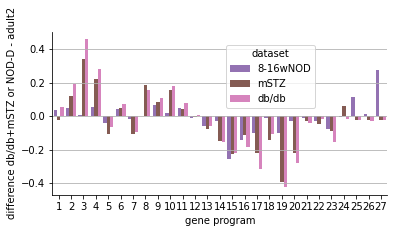

In [13]:
# Plot GP diffs
fig,ax=plt.subplots(figsize=(6,3))
sb.barplot(x="gp", y="diff",  data=diffs,
           hue='dataset',dodge=True,ax=ax,
          palette=dict(zip(adata_rn_b.uns['study_parsed_order'],
                           adata_rn_b.uns['study_parsed_colors']))
          )
ax.set_ylabel('difference db/db+mSTZ or NOD-D - adult2')
ax.set_xlabel('gene program')
ax.grid(axis='y')
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(0.8,0.95),title='dataset')

### Compare two diseased clusters in STZ dataset
db/db+mSTZ vs mSTZ for STZ dataset

In [14]:
# Compute GP differences between clusters
score_cols=[c for c in adata_rn_b.obs.columns if 
            c.startswith('gene_score_cluster_hc') and c.endswith('_scaled_out')]
cells1=adata_rn_b.obs.query('study=="STZ" & hc_gene_programs_parsed=="db/db+mSTZ"').index
cells2=adata_rn_b.obs.query('study=="STZ" & hc_gene_programs_parsed=="mSTZ"').index
print(study,'N cells cl1,2:',len(cells1),len(cells2))
diffs=pd.DataFrame(adata_rn_b.obs.loc[cells2,score_cols].mean()-\
                adata_rn_b.obs.loc[cells1,score_cols].mean()).rename({0:'diff'},axis=1)
diffs['gp']=[i.replace('gene_score_cluster_hc','').replace('_scaled_out','') 
         for i in diffs.index]
diffs['dataset']='mSTZ'

# Compute significance
diffs['pval']=np.nan
for gp in diffs.gp:
    gp_name='gene_score_cluster_hc'+gp+'_scaled_out'
    diffs.at[gp_name,'pval']=mannwhitneyu(
        adata_rn_b.obs.loc[cells2,gp_name].values,
        adata_rn_b.obs.loc[cells1,gp_name].values )[1]
diffs['padj']=multipletests(diffs['pval'],method='fdr_bh')[1]
display(diffs)

NOD_elimination N cells cl1,2: 2461 2620


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,-0.012783,1,mSTZ,1.861665e-08,2.513248e-08
gene_score_cluster_hc2_scaled_out,-0.124880,2,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc3_scaled_out,-0.074642,3,mSTZ,2.163426e-82,6.490278e-82
gene_score_cluster_hc4_scaled_out,-0.099063,4,mSTZ,2.872334e-207,2.585101e-206
gene_score_cluster_hc5_scaled_out,0.058449,5,mSTZ,2.978078e-103,1.005101e-102
gene_score_cluster_hc6_scaled_out,-0.001622,6,mSTZ,7.040966e-01,7.040966e-01
gene_score_cluster_hc7_scaled_out,-0.055481,7,mSTZ,1.437148e-49,2.984845e-49
gene_score_cluster_hc8_scaled_out,0.170385,8,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc9_scaled_out,-0.069801,9,mSTZ,5.727010e-144,3.865732e-143
gene_score_cluster_hc10_scaled_out,-0.063813,10,mSTZ,3.264332e-112,1.259099e-111


In [15]:
# Save diffs for combined plot
diffs_plot['mSTZ - db/db+mSTZ']=diffs

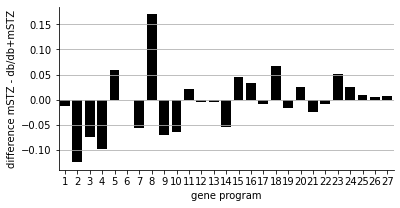

In [16]:
# Plot diffs
fig,ax=plt.subplots(figsize=(6,3))
sb.barplot(x="gp", y="diff",  data=diffs,
           dodge=True,ax=ax,color='k',
          )
ax.set_ylabel('difference mSTZ - db/db+mSTZ')
ax.set_xlabel('gene program')
ax.grid(axis='y')
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Healthy vs intermediate cluster for all datasets with diabetes models
adult2 vs D-inter. for VSG, STZ, and NOD_elim datasets

In [17]:
# Compute GP differences between clusters
score_cols=[c for c in adata_rn_b.obs.columns if 
            c.startswith('gene_score_cluster_hc') and c.endswith('_scaled_out')]
diffs=[]
for study in ['VSG',"STZ",'NOD_elimination']:
    cells1=adata_rn_b.obs.query('study==@study & hc_gene_programs_parsed=="adult2"').index
    cells2=adata_rn_b.obs.query('study==@study & hc_gene_programs_parsed=="D-inter."').index
    print(study,'N cells cl1,2:',len(cells1),len(cells2))
    diff=pd.DataFrame(adata_rn_b.obs.loc[cells2,score_cols].mean()-\
                    adata_rn_b.obs.loc[cells1,score_cols].mean()).rename({0:'diff'},axis=1)
    diff['gp']=[i.replace('gene_score_cluster_hc','').replace('_scaled_out','') 
             for i in diff.index]
    diff['dataset']=adata_rn_b.obs.query('study==@study')['study_parsed'][0]
    
    # Compute significance
    diff['pval']=np.nan
    for gp in diff.gp:
        gp_name='gene_score_cluster_hc'+gp+'_scaled_out'
        diff.at[gp_name,'pval']=mannwhitneyu(
            adata_rn_b.obs.loc[cells2,gp_name].values,
            adata_rn_b.obs.loc[cells1,gp_name].values )[1]
    diff['padj']=multipletests(diff['pval'],method='fdr_bh')[1]
    diffs.append(diff)
    display(diff)
diffs=pd.concat(diffs)
diffs['dataset']=pd.Categorical(
    values=diffs['dataset'],ordered=True,
    categories=[c for c in adata_rn_b.uns['study_parsed_order'] 
                if c in diffs['dataset'].unique()])

VSG N cells cl1,2: 1007 643


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,0.044127,1,db/db,1.931129e-18,3.067088e-18
gene_score_cluster_hc2_scaled_out,0.166083,2,db/db,2.820466e-155,3.807629e-154
gene_score_cluster_hc3_scaled_out,0.266948,3,db/db,1.179702e-168,3.185197e-167
gene_score_cluster_hc4_scaled_out,0.158865,4,db/db,7.471040e-120,3.361968e-119
gene_score_cluster_hc5_scaled_out,-0.070014,5,db/db,1.533097e-58,2.956687e-58
gene_score_cluster_hc6_scaled_out,0.014482,6,db/db,2.480652e-03,2.790734e-03
gene_score_cluster_hc7_scaled_out,-0.004889,7,db/db,5.559521e-01,5.559521e-01
gene_score_cluster_hc8_scaled_out,0.063516,8,db/db,6.186708e-66,1.518555e-65
gene_score_cluster_hc9_scaled_out,0.071049,9,db/db,4.018545e-56,7.233381e-56
gene_score_cluster_hc10_scaled_out,0.090204,10,db/db,3.022810e-63,6.278143e-63


STZ N cells cl1,2: 4766 1175


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,0.005865,1,mSTZ,2.420647e-02,2.513749e-02
gene_score_cluster_hc2_scaled_out,0.141516,2,mSTZ,2.076323e-304,2.803036e-303
gene_score_cluster_hc3_scaled_out,0.122707,3,mSTZ,0.000000e+00,0.000000e+00
gene_score_cluster_hc4_scaled_out,0.141130,4,mSTZ,1.559311e-260,1.403380e-259
gene_score_cluster_hc5_scaled_out,-0.098389,5,mSTZ,1.205221e-166,4.067623e-166
gene_score_cluster_hc6_scaled_out,0.024497,6,mSTZ,9.469394e-15,1.278368e-14
gene_score_cluster_hc7_scaled_out,0.042169,7,mSTZ,1.739817e-47,2.935941e-47
gene_score_cluster_hc8_scaled_out,0.013333,8,mSTZ,4.350376e-05,5.106963e-05
gene_score_cluster_hc9_scaled_out,0.019004,9,mSTZ,3.961070e-10,5.092804e-10
gene_score_cluster_hc10_scaled_out,0.063938,10,mSTZ,1.620137e-93,3.976700e-93


NOD_elimination N cells cl1,2: 504 130


,diff,gp,dataset,pval,padj
gene_score_cluster_hc1_scaled_out,0.052379,1,8-16wNOD,6.696764e-05,1.506772e-04
gene_score_cluster_hc2_scaled_out,0.055984,2,8-16wNOD,2.038417e-08,6.879659e-08
gene_score_cluster_hc3_scaled_out,0.008712,3,8-16wNOD,1.392006e-01,1.708372e-01
gene_score_cluster_hc4_scaled_out,0.047075,4,8-16wNOD,2.831940e-04,5.461599e-04
gene_score_cluster_hc5_scaled_out,-0.043583,5,8-16wNOD,8.394257e-08,2.518277e-07
gene_score_cluster_hc6_scaled_out,0.002911,6,8-16wNOD,8.389206e-01,8.711867e-01
gene_score_cluster_hc7_scaled_out,0.000837,7,8-16wNOD,9.044584e-01,9.044584e-01
gene_score_cluster_hc8_scaled_out,-0.024148,8,8-16wNOD,1.877657e-04,3.899750e-04
gene_score_cluster_hc9_scaled_out,0.045217,9,8-16wNOD,1.851243e-08,6.879659e-08
gene_score_cluster_hc10_scaled_out,0.007187,10,8-16wNOD,4.484212e-01,5.212663e-01


In [18]:
# Save diffs for combined plot
diffs_plot['D-inter. - adult2']=diffs

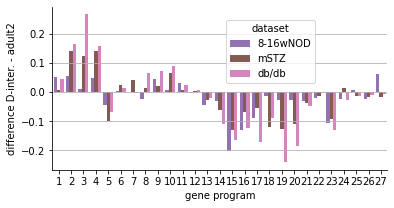

In [19]:
# plot diffs
fig,ax=plt.subplots(figsize=(6,3))
sb.barplot(x="gp", y="diff",  data=diffs,
           hue='dataset',dodge=True,ax=ax,
          palette=dict(zip(adata_rn_b.uns['study_parsed_order'],
                           adata_rn_b.uns['study_parsed_colors']))
          )
ax.set_ylabel('difference D-inter. - adult2')
ax.set_xlabel('gene program')
ax.grid(axis='y')
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(0.8,0.95),title='dataset')

### Combine all diffs into a single plot

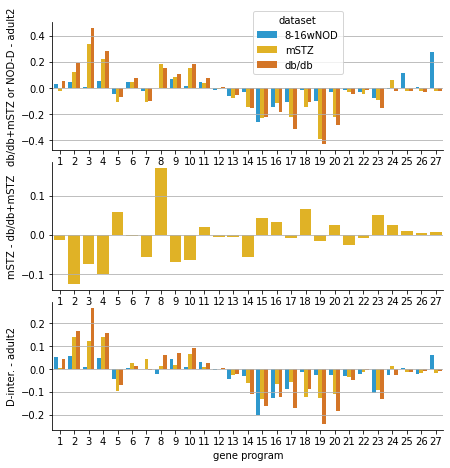

In [20]:
nrow=len(diffs_plot)
fig,axs=plt.subplots(nrow,1,figsize=(7,2.5*nrow),
                     #sharex=True,
                     sharey=False)
palette={'STZ':'#FFC107','VSG':'#F1720A','NOD_elimination':'#13A1E8'}
palette={adata_rn_b.obs.query('study==@s')['study_parsed'][0]:c for s,c in palette.items()}
plt.subplots_adjust( hspace=0.1)
for idx,(diff_name,diff) in enumerate(diffs_plot.items()):
    ax=axs[idx]
    sb.barplot(x="gp", y="diff",  data=diff,
           hue='dataset',dodge=True,ax=ax,
          palette=palette)
    ax.set_ylabel(diff_name)
    if idx==(nrow-1):
        ax.set_xlabel('gene program')
    else:
        ax.set_xlabel('')
    ax.grid(axis='y')
    #ax.grid(axis='x')
    ax.set(facecolor = (0,0,0,0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx==0:
        ax.legend(bbox_to_anchor=(0.5,0.55),title='dataset')
    else:
        ax.get_legend().remove()
plt.savefig(path_fig+'barplot_gpdiff_disease_interm_stz_perDataset.png',
            dpi=300,bbox_inches='tight')